# ロバストMDP

参考
* [Sample Complexity of Robust Reinforcement Learning with a Generative Model](https://arxiv.org/abs/2112.01506)
* [Robust dynamic programming](http://www.corc.ieor.columbia.edu/reports/techreports/tr-2002-07.pdf)
* [バナッハの不動点定理](https://mathlandscape.com/banach-fixed-pt/)

シミュレータを使ったアプリケーションではしばしば、シミュレータ上の遷移確率$P^o$で方策を学習させてから実世界にデプロイすることを考えます。
しかし、実世界の遷移確率は$P^o$に対して必ずズレがあります。
ロバストMDPでは$P^o$からのズレを含めた遷移確率の集合を$\mathcal{P}$として、$\mathcal{P}$の中の最悪ケースに対してもある程度の性能を保証するように学習することを目標にします。

ロバストMDPでのRLはロバスト動的計画法から派生してきています。
今回はロバスト動的計画法やロバストMDP用のアルゴリズム``Robust Empirical Value Iteration (REVI)``を確認してみます。

## ロバスト動的計画法

ロバストMDPの理論はいくつかありますが、最近のRLに関する結果はInfinite-horizonのケースが多いので、今回はInfinite-horizonの話をまとめます。
ちなみに今回の理論は全て$\inf_{P\in \mathcal{P}}$に関するものですが、楽観的な問題設定$\sup_{P\in \mathcal{P}}$を考えても成り立ちます。

次の問題設定を考えます。

**表記**

* 更新の回数：$K$
* エフェクティブホライズン：$H:=1 / (1 - \gamma)$
* 遷移確率のUncertainty set： $ \mathcal{P}=\otimes \mathcal{P}_{s, a}, \text { where, } \mathcal{P}_{s, a}=\left\{P_{s, a} \in[0,1]^{|\mathcal{S}|}: D\left(P_{s, a}, P_{s, a}^o\right) \leq c_r, \sum_{s^{\prime} \in \mathcal{S}} P_{s, a}\left(s^{\prime}\right)=1\right\}, $
    * ここで$D$は分布間の距離です。今回は特にf-ダイバージェンス$D_f(P \| Q)=\sum_x Q(x) f\left(\frac{P(x)}{Q(x)}\right)$を考えます。
* 遷移確率$P$での価値関数：$V_{\pi, P}(s)=\mathbb{E}_{\pi, P}\left[\sum_{t=0}^{\infty} \gamma^t r\left(s_t, a_t\right) \mid s_0=s\right]$
* $P$における最適価値関数と最適方策：$V_P^*=\max _\pi V_{\pi, P}, \quad \pi_P^*=\underset{\pi}{\arg \max } V_{\pi, P}$
* ロバストな価値関数と最適価値関数：$V^\pi=\inf _{P \in \mathcal{P}} V_{\pi, P}, \quad V^*=\sup _\pi \inf _{P \in \mathcal{P}} V_{\pi, P}$

---

**定理：マルコフ最適性**

方策集合が全ての方策を含むとき、ロバストな最適価値関数 $V^*=\sup_{\pi} \inf _{P \in \mathcal{P}} V_{\pi, P}$を与える$\pi$は決定的方策になる。

これの証明は通常のマルコフ決定過程とほぼ同じらしい。Puterman(1994)を見よう。

---

---

**ベルマン作用素**

* 任意のベクトル$v$と集合$\mathcal{B}$について、$\sigma_{\mathcal{B}}(v)=\inf \left\{u^{\top} v: u \in \mathcal{B}\right\}$とする。
* ロバストベルマン最適作用素：$T(V)(s)=\max _a(r(s, a)+ + \gamma \sigma_{\mathcal{P}_{s, a}}(V))$

ロバストベルマン最適作用素はcontractionになっている。つまり、任意の$U, V \in \mathcal{V}$について、

$$\|T U-T V\| \leq \gamma\|U-V\|$$

であり、また、$T$は唯一の解をもち、それは$V^*$である。

前半部分をまず証明します。$TU \geq TV$を仮定します。このとき、次を満たすように決定的方策$d$を選びます。

$$r\left(s, d(s)\right)+\gamma \inf _{p \in \mathcal{P}(s, d(s))} \mathbf{E}^p\left[U\left(s^{\prime}\right)\right] \geq T U(s)-\epsilon$$

続いて、次を満たすように$p_s \in \mathcal{P}(s, d(s))$を選びます。

$$r\left(s, d(s)\right)+\gamma \mathbf{E}^{p_s}\left[V\left(s^{\prime}\right)\right] \leq r\left(s, d(s)\right)+\lambda \inf _{p \in \mathcal{P}(s, d(s))} \mathbf{E}^p\left[V\left(s^{\prime}\right)\right]+\epsilon$$

これを使って変形すると、

$$
\begin{aligned}
0 \leq T U(s)- T V(s) & \leq\left(r\left(s, d(s)\right)+\gamma \inf _{p \in \mathcal{P}(s, d(s))} \mathbf{E}^p\left[U\left(s^{\prime}\right)\right]+\epsilon\right)- \left(r\left(s, d(s)\right)+\gamma\inf _{p \in \mathcal{P}(s, d(s))} \mathbf{E}^p\left[V\left(s^{\prime}\right)\right]\right), \\
& \leq \left(r\left(s, d(s)\right)+\gamma \mathbf{E}^{p_s}\left[U\left(s^{\prime}\right)\right]+\epsilon\right)-\left(r\left(s, d(s)\right)+\gamma \mathbf{E}^{p_s}\left[V\left(s^{\prime}\right)\right]-\epsilon\right), \\
& =\gamma \mathbf{E}^{p_s}[U-V]+2 \epsilon, \\
& \leq \gamma \mathbf{E}^{p_s}|U-V|+2 \epsilon, \\
& \leq \gamma\|U-V\|+2 \epsilon .
\end{aligned}
$$

これでcontractionが示せました。唯一の収束点の方は省略しますが、[バナッハの不動点定理](https://mathlandscape.com/banach-fixed-pt/)から不動点の存在は示せます。詳細は[Robust dynamic programming](http://www.corc.ieor.columbia.edu/reports/techreports/tr-2002-07.pdf)参照。

---


### $\sigma_{\mathcal{P}_{s, a}}(V)$について

ロバスト動的計画法では、$\sigma_{\mathcal{P}_{s, a}}(v)=\inf \left\{p^{\top} v: p \in \mathcal{P}_{s, a}\right\}$をとく必要があります。これは単純に制約付き最適化を実行すると非常に遅いですが、特定の制約の場合はラグランジュの未定乗数法を使えば効率的に解くことができます。　


**$D$がKLダイバージェンスのとき**

$D\left(p_1 \| p_2\right)=\sum_{s \in \mathcal{S}} p_1(s) \log \left(\frac{p_1(s)}{p_2(s)}\right)$の場合を考えましょう。

定義より$\sigma_{\mathcal{P}_{s, a}}(v)$は$t > 0$について
$$
\begin{array}{ll}
\text { minimize }_p & p^{\top} v\\
\text { subject to } & p \in \mathcal{P}=\{p \in [0, 1]^{|\mathcal{S}|}: D(p \| q) \leq t, \sum_{s\in \mathcal{S}}p(s)=1\}
\end{array}
$$
でした（$t$は$c_\tau$と、$q$は$P_{s, a}^o$と読み替えてください）。
この解は

$$
-\min _{\lambda \geq 0}t \lambda+\lambda \log \left(q^T\exp \left(-\frac{v}{\lambda}\right)\right)
$$

と等価です。

簡単に示してみましょう。まず、制約付き最適化問題のラグランジアンは$\lambda \geq 0$と$\mu \in \mathbb{R}$について、

$$\mathcal{L}=\sum_{s \in \mathcal{S}} p(s) v(s)-\lambda\left(t-\sum_{s \in \mathcal{S}} p(s) \log \left(\frac{p(s)}{q(s)}\right)\right)-\mu\left(\sum_{s \in \mathcal{S}} p(s)-1\right)$$

です。これを$p(s)$について微分すれば、

$$
\lambda \log \left(\frac{p(s)}{q(s)}\right)+v(s)=\mu-\lambda
$$

を得ます。これを$p(s)$について解けば

$$p(s)=q(s) \exp \left(-1+\frac{\mu-v(s)}{\lambda}\right)$$

です。
$\sum_{s \in \mathcal{S}} p(s)=1$を使ってラグランジアンを変形すると

$$\mathcal{L}=\sum_{s \in \mathcal{S}} p(s) \left(v(s) + \lambda \log \left(\frac{p(s)}{q(s)}\right) \right)-\lambda t
=\mu - \lambda -\lambda t
$$

です。
また、$p(s)=q(s) \exp \left(-1+\frac{\mu-v(s)}{\lambda}\right)$と$\sum_{s \in \mathcal{S}} p(s)=1$を合わせると、

$$\exp\left(\frac{\mu-\lambda}{\lambda}\right)\sum_{s \in \mathcal{S}} q(s) \exp \left(\frac{-v(s)}{\lambda}\right) = 1$$
より、

$$\mu-\lambda = -\lambda \log \left(\sum_{s \in \mathcal{S}} q(s) \exp \left(\frac{-v(s)}{\lambda}\right)\right)$$

なので、$\mathcal{L}(\lambda)=-t \lambda-\lambda \log \left(q^T\exp \left(\frac{v}{\lambda}\right)\right)$
を最大化させる$\lambda \geq 0$で元の問題が解けます。

ちなみにこの問題を解く計算量は$\widetilde{\mathcal{O}}(|\mathcal{S}|)$になります。（
[Robust dynamic programming](http://www.corc.ieor.columbia.edu/reports/techreports/tr-2002-07.pdf)参照）

他の距離についても似たようなことができます。（[Robust dynamic programming](http://www.corc.ieor.columbia.edu/reports/techreports/tr-2002-07.pdf)参照）

### REVIアルゴリズム

\begin{equation}
\begin{aligned}
& \text { 1: } \text { Input: Loop termination number } K \\
& \text { 2: } \text { Initialize: } Q_0=0 \\
& \text { 3: Compute the empirical uncertainty set } \widehat{\mathcal{P}}=\otimes \widehat{\mathcal{P}}_{s, a} \text {, where, } \widehat{\mathcal{P}}_{s, a}=\left\{P \in[0,1]^{\mathcal{S}} : D\left(P_{s, a}, \widehat{P}_{s, a}\right) \leq c_r, \sum_{s^{\prime} \in \mathcal{S}} P_{s, a}\left(s^{\prime}\right)=1\right\} \\
& \text { 4: } \text { for } k=0, \cdots, K-1 \text { do } \\
& \text { 5: } \quad V_k(s)=\max _a Q_k(s, a), \forall s \\
& \text { 6: } \quad Q_{k+1}(s, a)=r(s, a)+\gamma \sigma_{\widehat{\mathcal{P}}_{s, a}}\left(V_k\right), \forall(s, a) \\
& \text { 7: end for } \\
& \text { 8: Output: } \pi_K(s)=\arg \max _a Q_K(s, a), \forall s \in \mathcal{S}
\end{aligned}
\end{equation}

このアルゴリズムではGenerative model (シミュレータ)を仮定しています。なので探索が不要です。

実験してみましょう。
[Sample Complexity of Robust Reinforcement Learning with a Generative Model](https://arxiv.org/abs/2112.01506)のGambler's problemをちょっと変えて実験してみます。
([double chain MDP](reward_free_RL.ipynb)のマルチアクション版を考えます。）

In [41]:
import numpy as np
from itertools import product
from functools import partial
from typing import Optional, NamedTuple
import jax.numpy as jnp

def create_rew_P(S: int, A: int, head_prob: float):
    """ Gambler's Problem (報酬関数, 遷移確率) を作成します

    Args:
        S (int): 状態空間のサイズ
        A (int): 行動空間のサイズ
        head_prob (float): コインの表が出る確率

    Returns:
        rew (float): 報酬関数
        P (float): 遷移確率
    """

    # 一番右側の状態で1がもらえます
    # s=1を一番左側の状態として、s=0は吸収状態とします
    rew = np.zeros((S, A))
    rew[-1] = 1.0

    # コインの表が出ると右に、裏が出ると左に動きます。動く距離は行動の数に従います。
    P = np.zeros((S, A, S))
    for s, a in product(range(S), range(A)):
        if s == 0 or s == 1 or s == S - 1:  # 吸収状態か左端か右端
            P[s, a, 0] = 1
            continue
            
        next_s_down = max(1, s-a)  # 裏が出る
        next_s_up = min(s+a, S-a)  # 表が出る
        if next_s_down == next_s_up:
            P[s, a, next_s_down] = 1
        else:
            P[s, a, next_s_down] = 1 - head_prob
            P[s, a, next_s_up] = head_prob
    np.testing.assert_almost_equal(P.sum(axis=-1), 1)
    return jnp.array(rew), jnp.array(P)


class MDP(NamedTuple):
    S_array: np.array  # 状態空間
    A_array: np.array  # 行動空間
    gamma: float  # 割引率
    horizon: int  # エフェクティブホライゾン
    rew: float  # 報酬関数
    P: float  # 遷移確率
    optimal_Q: Optional[np.ndarray] = None  # 最適Q値
    robust_optimal_Q: Optional[np.ndarray] = None  # ロバスト最適Q値

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_array)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_array)


S = 20
A = 8
S_array = np.arange(S)
A_array = np.arange(A)
gamma = 0.95
horizon = int(1 / (1 - gamma)) * 2
head_prob = 0.6

# Double chain MDP を作ります
rew, P = create_rew_P(S, A, head_prob)
double_chain = MDP(S_array, A_array, gamma, horizon, rew, P)

# 実験に便利な関数

実験の前に、いくつか便利な関数を導入します。

1. ``compute_greedy_policy``: Q関数 ($S \times A \to \mathcal{R}$) の貪欲方策を返します
2. ``compute_optimal_Q``: MDPの最適Q関数 $q_* : S \times A \to \mathcal{R}$ を返します。
3. ``compute_policy_Q``: 方策 $\pi$ のQ関数 $q_\pi : S \times A \to \mathcal{R}$ を返します。
4. ``sample_next_state``: $(s, a)$の次の状態をサンプルします。

In [42]:
import jax
from functools import partial
from tqdm import tqdm
from jax.random import PRNGKey
import random
from functools import partial


# >>>> 1 >>>>
@jax.jit
def compute_greedy_policy(Q: np.ndarray):
    greedy_policy = jnp.zeros_like(Q)
    S, A = Q.shape
    greedy_policy = greedy_policy.at[jnp.arange(S), Q.argmax(axis=1)].set(1)
    assert greedy_policy.shape == (S, A)
    return greedy_policy
# <<<< 1 <<<<


# >>>> 2 >>>>
@partial(jax.jit, static_argnames=("S", "A"))
def _compute_optimal_Q(mdp: MDP, S: int, A: int):

    def backup(optimal_Q):
        max_Q = optimal_Q.max(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon, body_fn, optimal_Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.S, mdp.A)
# <<<< 2 <<<<


# >>>> 3 >>>>
@jax.jit
def compute_policy_Q(mdp: MDP, policy: np.ndarray):
    S, A = policy.shape

    def backup(policy_Q):
        max_Q = (policy * policy_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    policy_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon, body_fn, policy_Q)
# <<<< 3 <<<<


# >>>> 4 >>>>
@partial(jax.vmap, in_axes=(None, 0, 0))
def sample_next_state(mdp: MDP, key: PRNGKey, sa: int):
    """ sample next state according to the transition matrix P
    Args:
        mdp: MDP
        sa: int
    Returns:
        next_s: int
    """
    S, A, S = mdp.P.shape
    P = mdp.P.reshape(S * A, S)
    return jax.random.choice(key, mdp.S_array, p=P[sa])
# <<<< 4 <<<<

double_chain = double_chain._replace(optimal_Q=compute_optimal_Q(double_chain))

ロバストRLでは制約付き最適化問題を解く必要があります。
* $ \mathcal{P}=\otimes \mathcal{P}_{s, a}, \text { where, } \mathcal{P}_{s, a}=\left\{P_{s, a} \in[0,1]^{|\mathcal{S}|}: D\left(P_{s, a}, P_{s, a}^o\right) \leq c_r, \sum_{s^{\prime} \in \mathcal{S}} P_{s, a}\left(s^{\prime}\right)=1\right\}, $
* $\sigma_{\mathcal{\mathcal{P}_{s, a}}}(v)=\inf \left\{u^{\top} v: u \in \mathcal{\mathcal{P}_{s, a}}\right\}$

これを効率的に解くために、次の問題を変わりに解きます：

$$
-\min _{\lambda \geq 0}c_r \lambda+\lambda \log \left((P_{s, a}^o)^T\exp \left(-\frac{v}{\lambda}\right)\right)
$$

この最適化問題をベースに、ロバストベルマン最適作用素を用意しておきます。

In [47]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_non_negative
from functools import partial


# Uncertainty setのハイパーパラメータです
cr = 0.1

def loss(lam, p, v):
    # log-sum-exp用のトリックです
    x = v / (lam + 1e-6)
    x_min = x.min()
    logsumexp = - x_min + jnp.log(p @ jnp.exp(-x + x_min) + 1e-6)
    return cr * lam + lam * logsumexp

@partial(jax.vmap, in_axes=(0, 0, None))
def vmap_loss(lam, p, v):
    # log-sum-exp用のトリックです
    x = v / (lam + 1e-6)
    x_min = x.min()
    logsumexp = - x_min + jnp.log(p @ jnp.exp(-x + x_min) + 1e-6)
    return -(cr * lam + lam * logsumexp)


@partial(jax.jit, static_argnames=("S", "A"))
def _compute_robust_optimal_Q(mdp: MDP, S: int, A: int):
    # ロバストベルマン最適作用素です
    P = mdp.P.reshape(S*A, S)

    pg = ProjectedGradient(fun=loss, projection=projection_non_negative)
    init_w = jnp.ones(S*A) * 0.1

    def backup(optimal_Q):
        # 制約付き最適化を解きます
        v = optimal_Q.max(axis=1)
        res = jax.vmap(partial(pg.run, v=v))(init_w, None, P)
        lams = res.params
        next_v = vmap_loss(lams, P, v).reshape(S, A)
        return mdp.rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon, body_fn, optimal_Q)

compute_robust_optimal_Q = lambda mdp: _compute_robust_optimal_Q(mdp, mdp.S, mdp.A)
double_chain = double_chain._replace(robust_optimal_Q=compute_robust_optimal_Q(double_chain))


@jax.jit
def compute_robust_policy_Q(mdp: MDP, policy: np.ndarray):
    # ロバストベルマン期待作用素です
    S, A = policy.shape
    P = mdp.P.reshape(S*A, S)

    pg = ProjectedGradient(fun=loss, projection=projection_non_negative)
    init_w = jnp.ones(S*A) * 0.1

    def backup(policy_Q):
        # 制約付き最適化を解きます
        v = (policy * policy_Q).sum(axis=1)
        res = jax.vmap(partial(pg.run, v=v))(init_w, None, P)
        lams = res.params
        next_v = vmap_loss(lams, P, v).reshape(S, A)
        return mdp.rew + mdp.gamma * next_v
   
    policy_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon, body_fn, policy_Q)


greedy_policy = compute_greedy_policy(double_chain.robust_optimal_Q)
robust_policy_Q = compute_robust_policy_Q(double_chain, greedy_policy)
gap = np.abs(double_chain.robust_optimal_Q - robust_policy_Q).max()
print(f"「ロバスト最適価値」と「ロバスト最適方策から計算したロバスト期待価値」の差：{gap}")

greedy_policy = compute_greedy_policy(double_chain.optimal_Q)
robust_policy_Q = compute_robust_policy_Q(double_chain, greedy_policy)
gap = np.abs(double_chain.robust_optimal_Q - robust_policy_Q).max()
print(f"「ロバスト最適価値」と「最適方策から計算したロバスト期待価値」の差：{gap}")

「ロバスト最適価値」と「ロバスト最適方策から計算したロバスト期待価値」の差：3.874301910400391e-06
「ロバスト最適価値」と「最適方策から計算したロバスト期待価値」の差：0.006199643015861511


ロバスト最適作用素とロバスト期待作用素がそれなりに機能していそうです。（若干の数値エラーは出てますが許容します）
また、２つの遷移行列の距離を測る関数も用意しておきます。

In [48]:
# ２つの遷移確率間のf-divergenceを返します
def compute_f_div(P1: np.ndarray, P2: np.ndarray, f, eps: float = 1e-7) -> np.ndarray:
    """ Compute f divergence of two transition matrixes
    Args:
        P1: transition matrix
        P2: transition matrix
        f: f-divergence function
        eps: small value to prevent nan
    Returns:
        f-divergence of each (s, a): SxA matrix
    """
    S, A, S = P1.shape
    div = (P2 * f((P1 + eps) / (P2 + eps))).sum(axis=-1)
    assert div.shape == (S, A)
    return div 


rew, P1 = create_rew_P(S, A, 0.1)
rew, P2 = create_rew_P(S, A, 0.6)

print("TV:", compute_f_div(P1, P2, lambda x: np.abs(x - 1) / 2).max())
print("X2:", compute_f_div(P1, P2, lambda x: (x - 1) ** 2).max())
print("KL:", compute_f_div(P1, P2, lambda x: x * np.log(x)).max())

TV: 0.49999994
X2: 1.0416663
KL: 0.550661


早速アルゴリズムを組んでみましょう。

In [49]:
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm

 
def VI(mdp: MDP, true_mdp: MDP):
    Q_table = compute_optimal_Q(mdp)
    greedy_policy = compute_greedy_policy(Q_table)
    Q_pi = compute_policy_Q(true_mdp, greedy_policy)
    optimality_gap = np.abs(true_mdp.optimal_Q - Q_pi).max()
    return optimality_gap


def robust_VI(mdp: MDP, true_mdp: MDP):
    Q_table = compute_robust_optimal_Q(mdp)
    greedy_policy = compute_greedy_policy(Q_table)
    Q_pi = compute_policy_Q(true_mdp, greedy_policy)
    optimality_gap = np.abs(true_mdp.optimal_Q - Q_pi).max()
    return optimality_gap


def empirical_VI(mdp: MDP, true_mdp: MDP, N: int):
    prng_key = PRNGKey(0)
    S, A = mdp.S, mdp.A

    # generative_modelを使ってPを推定します
    P_approx = np.zeros((S * A, S))
    SA_array = np.arange(S * A)
    for _ in range(N):
        _, prng_key = jax.random.split(prng_key)
        keys = jax.random.split(prng_key, num=S * A)
        next_s = sample_next_state(double_chain, keys, SA_array)
        P_approx[SA_array, next_s] += 1
    P_approx = P_approx / N
    P_approx = P_approx.reshape(S, A, S)

    # 推定したPのもとでValue iterationをします。
    approx_mdp = mdp._replace(P=P_approx)
    Q_table = compute_optimal_Q(approx_mdp)
    greedy_policy = compute_greedy_policy(Q_table)

    Q_pi = compute_policy_Q(true_mdp, greedy_policy)
    optimality_gap = np.abs(true_mdp.optimal_Q - Q_pi).max()
    return optimality_gap


def empirical_robust_VI(mdp: MDP, true_mdp: MDP, N: int):
    prng_key = PRNGKey(0)
    S, A = mdp.S, mdp.A

    # generative_modelを使ってPを推定します
    P_approx = np.zeros((S * A, S))
    SA_array = np.arange(S * A)
    for _ in range(N):
        _, prng_key = jax.random.split(prng_key)
        keys = jax.random.split(prng_key, num=S * A)
        next_s = sample_next_state(double_chain, keys, SA_array)
        P_approx[SA_array, next_s] += 1
    P_approx = P_approx / N
    P_approx = P_approx.reshape(S, A, S)

    # 推定したPのもとでrobust Value iterationをします。
    approx_mdp = mdp._replace(P=P_approx)
    Q_table = compute_robust_optimal_Q(approx_mdp)
    greedy_policy = compute_greedy_policy(Q_table)

    Q_pi = compute_policy_Q(true_mdp, greedy_policy)
    optimality_gap = np.abs(true_mdp.optimal_Q - Q_pi).max()
    return optimality_gap



N = 10

head_probs = []
VI_gaps = []
empirical_VI_gaps = []
robust_VI_gaps = []
empirical_robust_VI_gaps = []
KL_P = []

for head_prob in tqdm(range(3, 10)):
    # 真のMDPを用意します
    head_prob = head_prob / 10
    rew, P = create_rew_P(S, A, head_prob)
    true_double_chain = MDP(S_array, A_array, gamma, horizon, rew, P)
    true_double_chain = true_double_chain._replace(optimal_Q=compute_optimal_Q(true_double_chain))


    # 真のMDPと今のMDPの遷移確率の差を記録します
    KL = compute_f_div(true_double_chain.P, double_chain.P, lambda x: x * np.log(x)).max()
    KL_P.append(KL)

    # 真のMDPでのパフォーマンスを記録します
    VI_gaps.append(VI(double_chain, true_double_chain))
    empirical_VI_gaps.append(empirical_VI(double_chain, true_double_chain, N))
    robust_VI_gaps.append(robust_VI(double_chain, true_double_chain))
    empirical_robust_VI_gaps.append(empirical_robust_VI(double_chain, true_double_chain, N))
    head_probs.append(head_prob)

100%|██████████| 7/7 [00:14<00:00,  2.01s/it]


Text(0.5, 0, 'head prob')

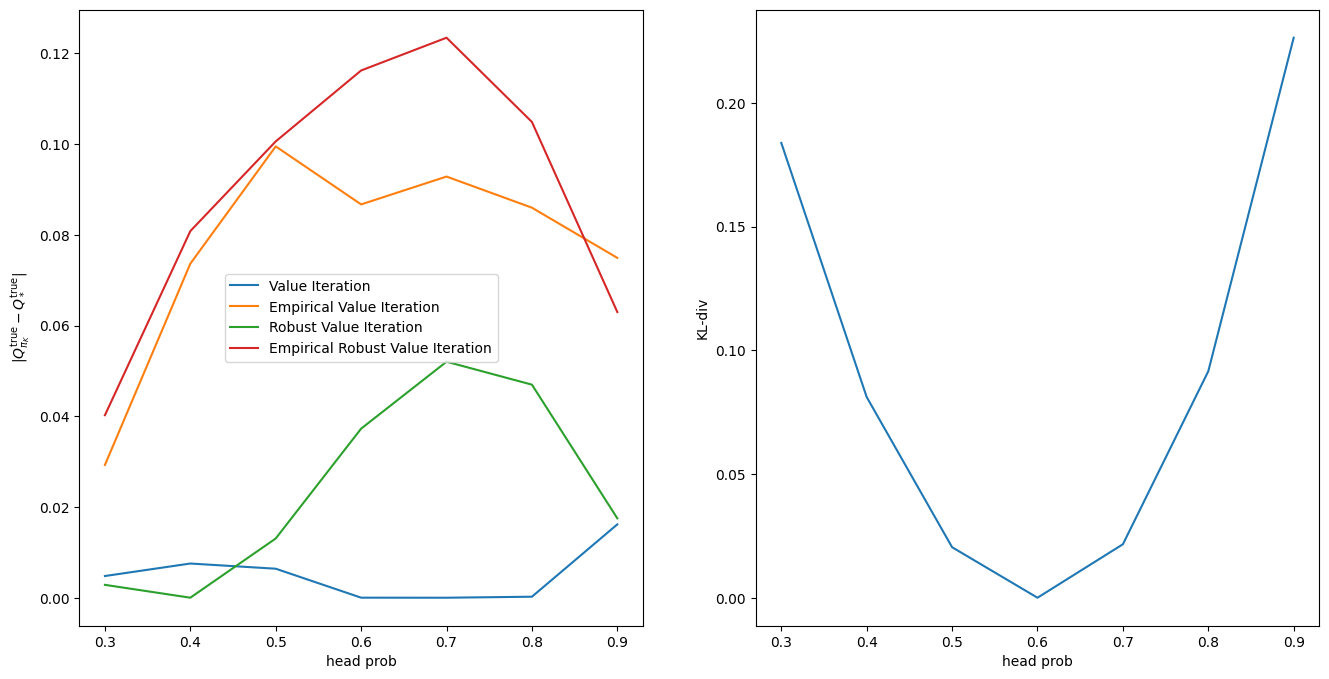

In [50]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(head_probs, VI_gaps, label="Value Iteration")
plt.plot(head_probs, empirical_VI_gaps, label="Empirical Value Iteration")
plt.plot(head_probs, robust_VI_gaps, label="Robust Value Iteration")
plt.plot(head_probs, empirical_robust_VI_gaps, label="Empirical Robust Value Iteration")
plt.ylabel(r"$\|Q_{\pi_K}^{\mathrm{true}} - Q_*^{\mathrm{true}}\|$")
plt.xlabel("head prob")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(head_probs, KL_P)
plt.ylabel("KL-div")
plt.xlabel("head prob")

いまいち結果が良いのかわかんないですね。
評価指標が悪いかもしれないな...